# Are homophones more likely to be from different grammatical classes?

Lexical ambiguity (E.g. homophones) could cause confusion for language learners/listeners. However, some (Piantadosi et al, 2012; Ferreira, 2008) argue that the distribution of *actual* ambiguity in language is less than imagined, because **context** usually serves to disambiguate.

If languages self-organize in such a way as to minimize potential ambiguities, the question becomes: *which* contextual cues are made available to help adjudicate (or, alternatively, *predict*) the intended meaning of a homophone? 

Previous work (see other report) suggests that homophones are not more **dissimilar** in meaning, as measured by the distance between their word embeddings; on average, homophone pairs were about as similar in meaning as other word pairs, with the exception of ~46 homophone pairs that were *more* similar (which might be due to common misspellings). 

Another possible disambiguating cue is **grammatical class**. Previous work (Dautriche et al, 2015; Dautriche, 2015) suggests that language learners are better able to learn novel meanings of a known word form (E.g. homophones) when the novel meaning is of a different grammatical class. In other words, **distinct syntactic context** helps learners form distinct lexical representations. 

Having observed that:
a) Homophones don't appear in *less* similar contexts overall than non-homophonous word pairs, as measured by *word2vec* similarity; and
b) Grammatical class *can* be a useful cue for disambiguation in the case of lexical ambiguity;

One prediction would be that homophones should be more likely than non-homophonous word pairs to be from different word classes.

## Dataset

We consider the set of monosyllabic, monomorphemic words from CELEX. We also pre-process this list in the following ways:

1) For all homographic homophone sets (e.g. "bank" and "bank"), we consider only the highest-frequency member of that set.  
2) For all words with an alternate spelling (e.g. "djinn" and "jinn"), we remove both entries.  
3) We also remove letters (other than "a"), abbreviations (e.g. "wt" or "lb"), and non-English entries ("si" or "ti"). 

In [29]:
import pandas as pd
from tqdm import tqdm
import itertools
import editdistance as ed

import numpy as np
%matplotlib inline

In [6]:
CELEX_PATH = "../data/processed/celex_processed.csv"
df = pd.read_csv(CELEX_PATH)
print("#Words: {num}\n".format(num=len(df)))

#Words: 3877



We then filter this list to contain only those words which contain a heterographic homophone, as identified in a previous analysis.

In [7]:
df_homophones = pd.read_csv("../data/processed/homophone_comparisons.csv")
homophones = list(df_homophones['w1']) + list(df_homophones['w2'])
print("Filtering on words that have a homophone pair...")
df = df[df['Word'].isin(homophones)]
print("#Words after: {num}\n".format(num=len(df)))

Filtering on words that have a homophone pair...
#Words after: 569



Next, to simplify the comparison process, we build a new representation for each entry, concatenating the grammatical class and phonetic representation into a single string.

In [9]:
df['new_repr'] = df['PhonDISC'] + "**" + df['Class']
df.head(5)

,Unnamed: 0,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,id,new_repr
4,404,ad,0.95,1,{d,N,1,404,{d**N
5,423,add,2.37,1,{d,V,1,423,{d**V
12,855,aid,1.78,1,1d,N,1,855,1d**N
13,857,aide,1.00,1,1d,N,1,857,1d**N
14,861,ail,1.04,1,1l,V,1,861,1l**V


## Analysis

For the analysis, we first consider the **true distribution** of homophone pairs, and count the number of pairs that come from the same class, vs. those who don't. We derive a ratio, e.g. **same class / different class**.

We then shuffle our dataset a number of times, and for each permutation, we derive a ratio for that presumably random distribution. Each of these ratios should represent the proportion of homophones with same vs. different classes if this relationship was random.

Ultimately , we compare our **true ratio** to the distribution of ratios from each shuffle. 

Predictions:

1) If homophones are more likely to come from distinct grammatical categories, the true ratio of same to different classes should be **much lower** than the distribution of ratios from our shuffles.  
2) If homophones are more likely to be in the *same* grammatical class, the true ratio should be much **greater**.  
3) If there is no relationship between homophony and grammatical class, the true ratio should fall somewhere in the **middle** of our shuffled distribution.

In [18]:
def compare_words(words):
    """Given a list of word representations (and their syntactic category), return dataframe illustrating
    whether words with identical representations are more likely to come from the same category.
    
    Assumes each entry looks like this: "PHONETIC**CLASS", e.g. the phonetic representation comes first, followed
    by a ** separator, then followed by the grammatical class.
    
    Parameters
    ----------
    words: list
      list of representations (see above for description)
    
    Returns
    -------
    pandas.DataFrame
      dataframe with an entry for each comparison, indicating whether 
      they come from the same class, and whether they have the same phonetic
      representations.
    """
    analysis = []
    combinations = list(itertools.combinations(words, 2))

    for w1, w2 in tqdm(combinations):
        # If nan, ignore
        if type(w1) == float or type(w2) == float:
            continue
        phon1, class1 = w1.split("**")
        phon2, class2 = w2.split("**")

        same_class = class1 == class2

        difference = ed.eval(phon1, phon2)
        is_homophone = True if difference == 0 else False
        analysis.append({
            'same_class': same_class,
            'is_homophone': is_homophone
            })
    return pd.DataFrame(analysis)

In [19]:
def get_ratios(df_analysis):
    """Given the dataframe from above, derive ratios of same class to different classes."""
    true_ratio_homophones = len(df_analysis[(df_analysis['is_homophone']==True) & (df_analysis['same_class']==True)]) / len(df_analysis[(df_analysis['is_homophone']==True) & (df_analysis['same_class']==False)])
    true_ratio_non = len(df_analysis[(df_analysis['is_homophone']==False) & (df_analysis['same_class']==True)]) / len(df_analysis[(df_analysis['is_homophone']==False) & (df_analysis['same_class']==False)])
    return true_ratio_homophones, true_ratio_non

In [20]:
df_analysis = compare_words(df['new_repr'])
true_ratios = get_ratios(df_analysis)

100%|██████████| 161596/161596 [00:00<00:00, 327409.77it/s]


In [21]:
df_analysis.head(5)

,is_homophone,same_class
0,True,False
1,False,True
2,False,True
3,False,False
4,False,True


In [22]:
print("The ratio of homophones from the same class to homophones from different classes is: {rat}".format(rat=true_ratios[0]))

The ratio of homophones from the same class to homophones from different classes is: 0.585


In [23]:
print("The ratio of non_homophones from the same to different class is: {rat}".format(rat=true_ratios[1]))

The ratio of non_homophones from the same to different class is: 0.7648137573574629


### Monte Carlo Simulation

In [24]:
ITERATIONS = 100

In [26]:
homophone_shuffle_ratios, non_homophone_shuffle = [], []
to_permute = list(df['Class'])

In [27]:
for iteration in range(ITERATIONS):
    print(iteration)
    permuted = np.random.permutation(to_permute)
    new_repr = df['PhonDISC'] + "**" + permuted
    df_analysis_copy = compare_words(new_repr)
    new_ratios = get_ratios(df_analysis_copy)
    homophone_shuffle_ratios.append(new_ratios[0])
    non_homophone_shuffle.append(new_ratios[1])

 39%|███▊      | 62393/161596 [00:00<00:00, 295883.30it/s]

0


 40%|████      | 64895/161596 [00:00<00:00, 323594.27it/s]

1


 38%|███▊      | 61800/161596 [00:00<00:00, 296436.83it/s]

2


 20%|█▉        | 32139/161596 [00:00<00:00, 321383.41it/s]

3


 40%|███▉      | 64122/161596 [00:00<00:00, 320657.06it/s]

4


 41%|████      | 66166/161596 [00:00<00:00, 326291.04it/s]

5


 18%|█▊        | 28847/161596 [00:00<00:00, 288464.09it/s]

6


 20%|██        | 32543/161596 [00:00<00:00, 325429.53it/s]

7


 20%|██        | 33058/161596 [00:00<00:00, 330577.16it/s]

8


 19%|█▉        | 30733/161596 [00:00<00:00, 307329.56it/s]

9


 19%|█▉        | 31505/161596 [00:00<00:00, 315043.54it/s]

10


 20%|██        | 32846/161596 [00:00<00:00, 328453.27it/s]

11


 40%|███▉      | 64207/161596 [00:00<00:00, 315855.20it/s]

12


 41%|████▏     | 66841/161596 [00:00<00:00, 334861.31it/s]

13


 21%|██        | 33630/161596 [00:00<00:00, 336289.90it/s]

14


 21%|██        | 33172/161596 [00:00<00:00, 331717.15it/s]

15


 41%|████      | 66302/161596 [00:00<00:00, 331383.20it/s]

16


 20%|█▉        | 31861/161596 [00:00<00:00, 318603.47it/s]

17


 20%|█▉        | 31552/161596 [00:00<00:00, 315519.55it/s]

18


 21%|██        | 33278/161596 [00:00<00:00, 332776.35it/s]

19


 16%|█▌        | 25932/161596 [00:00<00:00, 259317.16it/s]

20


 40%|████      | 64876/161596 [00:00<00:00, 325083.29it/s]

21


 21%|██        | 33567/161596 [00:00<00:00, 335666.32it/s]

22


 21%|██        | 33708/161596 [00:00<00:00, 337066.66it/s]

23


 39%|███▉      | 63328/161596 [00:00<00:00, 321723.71it/s]

24


 41%|████      | 66491/161596 [00:00<00:00, 336651.79it/s]

25


 21%|██        | 34164/161596 [00:00<00:00, 341639.51it/s]

26


 23%|██▎       | 36563/161596 [00:00<00:00, 365626.86it/s]

27


 19%|█▊        | 29978/161596 [00:00<00:00, 299776.71it/s]

28


 35%|███▌      | 56749/161596 [00:00<00:00, 290169.48it/s]

29


 17%|█▋        | 27867/161596 [00:00<00:00, 278661.63it/s]

30


 20%|█▉        | 31678/161596 [00:00<00:00, 316777.28it/s]

31


 21%|██        | 33838/161596 [00:00<00:00, 338379.52it/s]

32


 18%|█▊        | 29864/161596 [00:00<00:00, 298639.57it/s]

33


 17%|█▋        | 27073/161596 [00:00<00:00, 270727.68it/s]

34


 40%|███▉      | 64059/161596 [00:00<00:00, 308780.59it/s]

35


 17%|█▋        | 27436/161596 [00:00<00:00, 274356.99it/s]

36


 14%|█▍        | 22974/161596 [00:00<00:00, 229739.67it/s]

37


 20%|██        | 32454/161596 [00:00<00:00, 324533.35it/s]

38


 18%|█▊        | 28423/161596 [00:00<00:00, 284221.46it/s]

39


 39%|███▊      | 62457/161596 [00:00<00:00, 305302.40it/s]

40


 34%|███▍      | 54908/161596 [00:00<00:00, 274523.30it/s]

41


 20%|██        | 32395/161596 [00:00<00:00, 323947.22it/s]

42


 18%|█▊        | 29578/161596 [00:00<00:00, 295774.64it/s]

43


 21%|██        | 33289/161596 [00:00<00:00, 332889.52it/s]

44


 16%|█▌        | 25587/161596 [00:00<00:00, 255867.19it/s]

45


 18%|█▊        | 28474/161596 [00:00<00:00, 284734.16it/s]

46


 16%|█▌        | 26162/161596 [00:00<00:00, 261614.64it/s]

47


 41%|████      | 65695/161596 [00:00<00:00, 318326.37it/s]

48


 18%|█▊        | 29511/161596 [00:00<00:00, 295107.47it/s]

49


 39%|███▊      | 62426/161596 [00:00<00:00, 306891.07it/s]

50


 19%|█▉        | 31408/161596 [00:00<00:00, 314071.31it/s]

51


 20%|█▉        | 31836/161596 [00:00<00:00, 318357.27it/s]

52


 20%|██        | 32666/161596 [00:00<00:00, 326653.30it/s]

53


 38%|███▊      | 61441/161596 [00:00<00:00, 298480.39it/s]

54


 36%|███▌      | 58181/161596 [00:00<00:00, 290671.34it/s]

55


 19%|█▉        | 30531/161596 [00:00<00:00, 305307.38it/s]

56


 19%|█▉        | 30835/161596 [00:00<00:00, 308343.68it/s]

57


 38%|███▊      | 61856/161596 [00:00<00:00, 309132.26it/s]

58


 17%|█▋        | 28272/161596 [00:00<00:00, 282705.44it/s]

59


 16%|█▋        | 26554/161596 [00:00<00:00, 265535.19it/s]

60


 21%|██        | 33680/161596 [00:00<00:00, 336796.31it/s]

61


 17%|█▋        | 27471/161596 [00:00<00:00, 274640.85it/s]

62


 20%|█▉        | 31550/161596 [00:00<00:00, 315493.53it/s]

63


 40%|███▉      | 64615/161596 [00:00<00:00, 327822.02it/s]

64


 22%|██▏       | 35688/161596 [00:00<00:00, 356876.94it/s]

65


 42%|████▏     | 68094/161596 [00:00<00:00, 344285.40it/s]

66


 22%|██▏       | 35320/161596 [00:00<00:00, 353196.13it/s]

67


 44%|████▍     | 71394/161596 [00:00<00:00, 359932.00it/s]

68


 42%|████▏     | 67917/161596 [00:00<00:00, 339475.43it/s]

69


 44%|████▍     | 70853/161596 [00:00<00:00, 351190.54it/s]

70


 42%|████▏     | 67662/161596 [00:00<00:00, 339027.32it/s]

71


 43%|████▎     | 69726/161596 [00:00<00:00, 348623.18it/s]

72


 42%|████▏     | 67359/161596 [00:00<00:00, 340059.26it/s]

73


 20%|██        | 32662/161596 [00:00<00:00, 326616.42it/s]

74


 37%|███▋      | 59642/161596 [00:00<00:00, 295669.47it/s]

75


 20%|█▉        | 31800/161596 [00:00<00:00, 317986.66it/s]

76


 19%|█▊        | 29947/161596 [00:00<00:00, 299461.00it/s]

77


 20%|█▉        | 31619/161596 [00:00<00:00, 316111.17it/s]

78


 39%|███▊      | 62400/161596 [00:00<00:00, 308956.98it/s]

79


 39%|███▉      | 63731/161596 [00:00<00:00, 319717.88it/s]

80


 19%|█▉        | 31015/161596 [00:00<00:00, 310140.68it/s]

81


 17%|█▋        | 27871/161596 [00:00<00:00, 278701.63it/s]

82


 41%|████      | 65563/161596 [00:00<00:00, 321311.77it/s]

83


 18%|█▊        | 28426/161596 [00:00<00:00, 284254.85it/s]

84


 17%|█▋        | 27620/161596 [00:00<00:00, 276192.36it/s]

85


 35%|███▌      | 57301/161596 [00:00<00:00, 283098.49it/s]

86


 19%|█▉        | 30357/161596 [00:00<00:00, 303564.50it/s]

87


 18%|█▊        | 28849/161596 [00:00<00:00, 288484.77it/s]

88


 18%|█▊        | 29185/161596 [00:00<00:00, 291704.23it/s]

89


 18%|█▊        | 29880/161596 [00:00<00:00, 298799.57it/s]

90


 38%|███▊      | 61808/161596 [00:00<00:00, 306389.35it/s]

91


 38%|███▊      | 61257/161596 [00:00<00:00, 301234.95it/s]

92


 36%|███▌      | 57863/161596 [00:00<00:00, 288068.57it/s]

93


 18%|█▊        | 29104/161596 [00:00<00:00, 291034.03it/s]

94


  6%|▌         | 9548/161596 [00:00<00:01, 95478.95it/s]

95


 39%|███▉      | 63375/161596 [00:00<00:00, 299516.02it/s]

96


 18%|█▊        | 29090/161596 [00:00<00:00, 290896.81it/s]

97


 39%|███▊      | 62298/161596 [00:00<00:00, 303758.18it/s]

98


 38%|███▊      | 61651/161596 [00:00<00:00, 308585.24it/s]

99


100%|██████████| 161596/161596 [00:00<00:00, 323050.59it/s]


Text(0.5,0,'Same class / Different class')

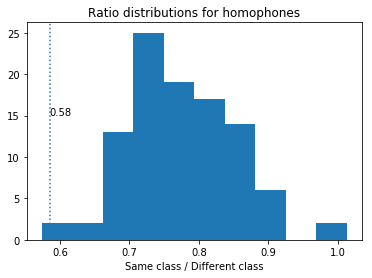

In [72]:
import matplotlib.pyplot as plt
plt.hist(homophone_shuffle_ratios)
plt.axvline(true_ratios[0], linestyle="dotted")
plt.text(true_ratios[0], 15, str(round(true_ratios[0], 2)))
plt.title("Ratio distributions for homophones")
plt.xlabel("Same class / Different class")

In [73]:
p_val_homophone_ratio = len([i for i in homophone_shuffle_ratios if i <= true_ratios[0]]) / len(homophone_shuffle_ratios)

In [74]:
print("Probability of getting a value at least that small: {p}".format(p=p_val_homophone_ratio))

Probability of getting a value at least that small: 0.01


Text(0.5,0,'Same class / Different class')

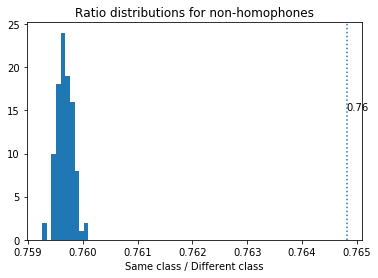

In [75]:
import matplotlib.pyplot as plt
plt.hist(non_homophone_shuffle)
plt.axvline(true_ratios[1], linestyle="dotted")
plt.text(true_ratios[1], 15, str(round(true_ratios[1], 2)))
plt.title("Ratio distributions for non-homophones")
plt.xlabel("Same class / Different class")

In [76]:
p_val_nonhomophone = len([i for i in non_homophone_shuffle if i >= true_ratios[1]]) / len(non_homophone_shuffle)
print("Probability of getting a value at least that large: {p}".format(p=p_val_nonhomophone))

Probability of getting a value at least that large: 0.0


# Conclusion

Based on the results of Monte Carlo simulations, we have two tentative conclusions:

1. Homophone pairs are more likely to be from **different classes** than the **same class**, at a ratio close to 1:2.   
2. Non-homophone pairs are also more likely be from different classes, though the true ratio is still *slightly* higher than one would expect (just above 3:4). 